In [257]:
# Cargar librerías
import pandas as pd  # Manejo de dataframes
import numpy as np  # Manejo de arrays

In [258]:
# Cargar datos de sqlite3
import sqlite3

conn = sqlite3.connect("data/df.db")  # Conectar a la base de datos (ruta)
df = pd.read_sql_query("SELECT * FROM df", conn)  # Leer la tabla df
conn.close()  # Cerrar la conexión
df.head()  # Mostrar las primeras 5 filas

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,...,mean_time,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,target,retirementDate,retirementType,resignationReason
0,51,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,...,7.373651,3.0,4.0,2.0,3,3,0,None,No,No
1,31,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,...,7.718969,3.0,2.0,4.0,2,4,1,2016-10-15 00:00:00,Resignation,Others
2,32,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,...,7.013240,2.0,2.0,1.0,3,3,0,None,No,No
3,38,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,...,7.193678,4.0,4.0,3.0,2,3,0,None,No,No
4,32,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,...,8.006175,4.0,1.0,3.0,3,3,0,None,No,No


In [259]:
# Quitar retirementDate, retirementType y retirementReason porque puede generar un sesgo en el modelo
df.drop(["retirementDate", "retirementType", "resignationReason"], axis=1, inplace=True)


# Reemplazar los valores nan de EnvironmentSatisfaction, JobSatisfaction y WorkLifeBalance por la moda de ese empleado en su departamento
df["EnvironmentSatisfaction"] = df.groupby("Department")[
    "EnvironmentSatisfaction"
].transform(lambda x: x.fillna(x.mode()[0]))

df["JobSatisfaction"] = df.groupby("Department")["JobSatisfaction"].transform(
    lambda x: x.fillna(x.mode()[0])
)
df["WorkLifeBalance"] = df.groupby("Department")["WorkLifeBalance"].transform(
    lambda x: x.fillna(x.mode()[0])
)

In [260]:
from sklearn.model_selection import train_test_split

# Separación de caracteristicas y target (X , y)
y = df.target
X = df.drop(["target"], axis=1)

# Separación en conjuntos de train y test 90% - 10%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Mostrar los tamaños de los conjuntos
print("Tamaño de X_train: ", X_train.shape)
print("Tamaño de X_test: ", X_test.shape)

Tamaño de X_train:  (3943, 25)
Tamaño de X_test:  (439, 25)


In [261]:
# Seleccionar variables numéricas int64 y float64
numeric_columns = list(X.select_dtypes(include=["int64", "float64"]).columns)
categorical_columns = list(X.select_dtypes("object").columns)

# Estandarizar las variables numéricas
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Convertir a dummy las variables categóricas
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

La métrica que usaremos será el RECALL, teniendo en cuenta que por las caracteristicas del problema buscamos reducir al máximo que el algoritmo prediga que alguien no se va a ir cuando realmente si se va a ir (FALSOS NEGATIVOS) ya que esto le genera un costo muy elevado a la empresa y por otro lado, que el algoritmo prediga que alguien se va a ir cuando realmente no se va a ir (FALSOS POSITIVOS) no genera un costo tan elevado como el anterior.

# Modelos

In [267]:
# Métrica del modelo
from sklearn.metrics import recall_score

"""
RECALL: Queremos que tenga cuidado con falsos negativos
PRECISION: Queremos que tenga cuidado con falsos positivos
F1 SCORE: Es una combinación de recall y precision

"""
metric = "recall"  # Métrica de evaluación


# Lista de modelos que tienen más interpretabilidad para clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  # Ensamble con bagging
from sklearn.ensemble import GradientBoostingClassifier  # Ensamble con boosting
from xgboost import XGBClassifier  # Ensamble con boosting

models = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(),
}

# Entrenar los modelos
for model in models:
    models[model].fit(X_train, y_train)

# Evaluar los modelos con validación cruzada con 5 folds y métrica recall
from sklearn.model_selection import cross_validate

for model in models:
    cv_results = cross_validate(
        models[model],
        X_train,
        y_train,
        cv=10,
        n_jobs=-1,
        scoring=metric,
        return_train_score=True,
    )
    print(
        f"{model}\n{metric} mean train: {cv_results['train_score'].mean():.3f} +/- {cv_results['train_score'].std():.3f}\n{metric} mean test: {cv_results['test_score'].mean():.3f} +/- {cv_results['test_score'].std():.3f}\n"
    )

LogisticRegression
recall mean train: 0.258 +/- 0.008
recall mean test: 0.243 +/- 0.043

DecisionTreeClassifier
recall mean train: 1.000 +/- 0.000
recall mean test: 0.969 +/- 0.019

RandomForestClassifier
recall mean train: 1.000 +/- 0.000
recall mean test: 0.978 +/- 0.012

GradientBoostingClassifier
recall mean train: 0.576 +/- 0.010
recall mean test: 0.464 +/- 0.055

XGBClassifier
recall mean train: 1.000 +/- 0.000
recall mean test: 0.986 +/- 0.013



Podemos analizar lo siguiente:
* En la regresión logística, nos arroja un modelo sin overfitting, pero su recall es muy bajo, por lo que no es un buen modelo
* El GradientBoostingClassifier tiene un desempeño medio con overfitting, por lo que no es un buen modelo
* En DecisionTree, RandomForest y XGBClassifier vemos que tienen un buen desempeño, pero hay overfitting, ya que el recall en el conjunto de entrenamiento es muy alto, pero en el conjunto de prueba es bajo, por lo que no es un buen modelo, pero podemos mejorarlos con una búsqueda de hiperparámetros
* Tomaremos el XGBClassifier como modelo final, ya que tiene un buen desempeño además de tener una desviación estándar menor y podemos mejorar su overfitting con una búsqueda de hiperparámetros

# Optimización de hiperparámetros

In [263]:
# Optimizar hiperparámetros de XGBoost con GridSearchCV
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a optimizar
param_grid = {
    "max_depth": [3, 4, 5],
    "min_child_weight": [1],
    "gamma": [1],
    "learning_rate": [0.5],
}

# Definir el modelo
xgb = XGBClassifier(
    n_estimators=1000,  # Número de árboles
    eval_metric="logloss",  # Función de pérdida a optimizar, diferente a la métrica usada
    early_stopping_rounds=5,  # Detener el entrenamiento si no mejora en 10 iteraciones
    random_state=42,  # Semilla para reproducibilidad
)

# Definir la búsqueda
grid_search = GridSearchCV(
    xgb,
    param_grid,
    scoring=metric,
    cv=10,
    n_jobs=-1,
    return_train_score=True,
    verbose=1,
)

# Entrenar la búsqueda
grid_search.fit(
    X_train, y_train, verbose=False, eval_set=[(X_test, y_test), (X_train, y_train)]
)

# Mejores hiperparámetros y su recall en train y test
print(
    f"Mejores hiperparámetros: {grid_search.best_params_}\n{metric} train: {grid_search.cv_results_['mean_train_score'][grid_search.best_index_]:.3f}\n{metric} test: {grid_search.cv_results_['mean_test_score'][grid_search.best_index_]:.3f}"
)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Mejores hiperparámetros: {'gamma': 1, 'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 1}
recall train: 0.998
recall test: 0.961


# Mejor modelo

F1 train: 1.000
F1 test: 1.000


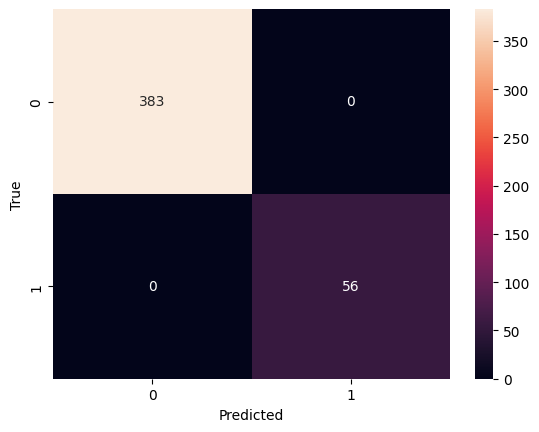

,Feature,Importance
44,MaritalStatus_Single,0.055371
19,BusinessTravel_Non-Travel,0.052380
25,EducationField_Human Resources,0.038896
22,Department_Human Resources,0.038484
41,JobRole_Sales Representative,0.037229
15,JobSatisfaction,0.031940
20,BusinessTravel_Travel_Frequently,0.031866
27,EducationField_Marketing,0.030866
33,JobRole_Healthcare Representative,0.028979
8,TotalWorkingYears,0.028814


In [117]:
# Seleccionar el mejor modelo con el mejor F1 en test
best_model = models["XGBClassifier"]

# Predecir con el mejor modelo
y_pred = best_model.predict(X_test)

# Evaluar F1 en train y test
from sklearn.metrics import f1_score

print(
    f"F1 train: {f1_score(y_train, best_model.predict(X_train)):.3f}\nF1 test: {f1_score(y_test, y_pred):.3f}"
)

# Matriz de confusión
from sklearn.metrics import confusion_matrix  # Matriz de confusión
import seaborn as sns  # Gráficos estadísticos
import matplotlib.pyplot as plt  # Gráficos

y_pred = best_model.predict(X_test)  # Predicciones
cm = confusion_matrix(y_test, y_pred)  # Matriz de confusión
sns.heatmap(cm, annot=True, fmt="d")  # Gráfico de la matriz de confusión
plt.xlabel("Predicted")  # Etiqueta eje x
plt.ylabel("True")  # Etiqueta eje y
plt.show()  # Mostrar gráfico

# Tabla de características más importantes
importances = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance": best_model.feature_importances_,
    }
)
importances.sort_values(by="Importance", ascending=False).head(
    25
)  # Ordenar por importancia y mostrar las 25 más importantes

# Gráfico de SHAP

El gráfico de SHAP nos sirve para dar interpretabilidad a los modelos de manera global, notemos como cambia el orden de las variables respecto a la tabla anterior

EXPLICACIÓN GRÁFICOS SHAP
* En el eje y izquierdo vemos la variables más importantes de acuerdo a su importancia absoluta
* El eje X nos muestra el valor SHAP. Hacia la derecha, tenemos un valor positivo, lo que indica que aumenta el valor de la predicción final. Hacia la izquierda, el valor es negativo, por lo que tendría el efecto contrario.
* La dimensión del color nos muestra el valor de la variable normalizado. En color rojo vemos valores altos de la variable, y en azul bajos.

In [17]:
# Importar librerías para calcular los SHAP values
import shap

explainer = shap.TreeExplainer(best_model)  # Crear el objeto explainer
shap_values = explainer.shap_values(X_train)  # Calcular los SHAP values

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


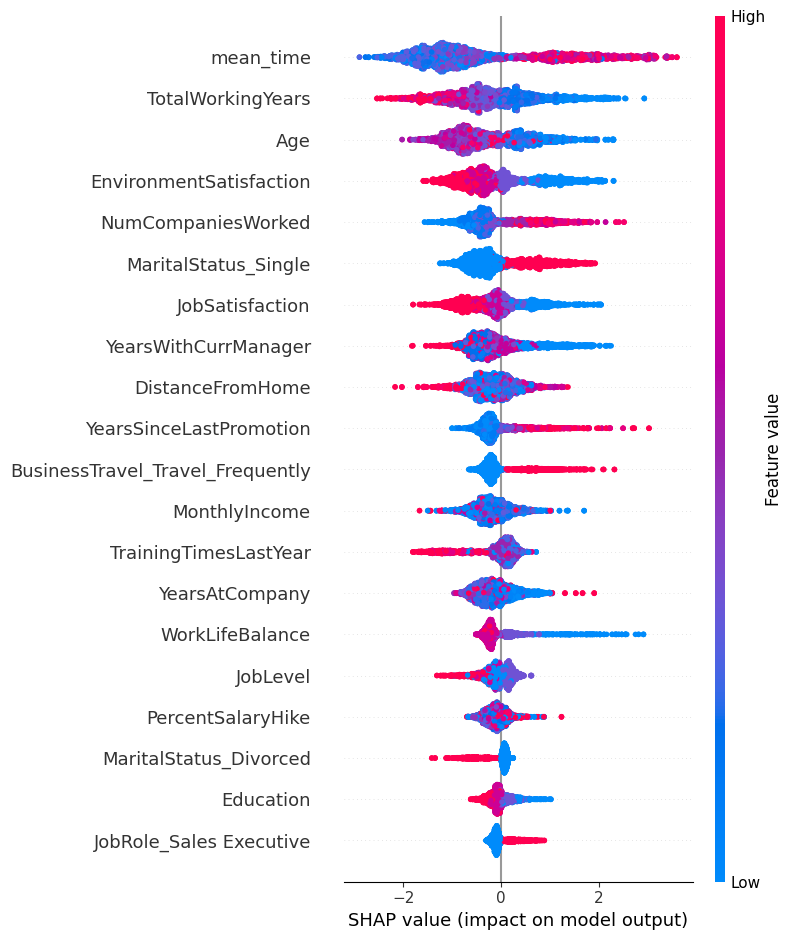

In [18]:
# Gráfico de barras de SHAP values para cada variable
shap.summary_plot(shap_values, X_train)

RESUMEN:
* Entre menos años haya trabajado hasta ahora ese empleado es más propenso a renunciar
* La edad se tomaría de la misma manera a valores bajos de la edad es más propenso a que renuncie
* En el numero de compañias pasa el caso contrario, si ha trabajado en muchas compañias, el empleado tiende a renunciar
* Entre menos años tengan con el actual director son más propensos a renunciar
* Los solteros tienden a renunciar
* En la parte de los ingresos mensuales es muy variable
* Entre más años hayan pasado desde el último asenso tienden a renunciar

Fuente de gráficos de SHAP
https://www.modeldifferently.com/2023/02/que-es-shap-explicabilidad-de-modelos-shap/